In [12]:
# read the LGMR_SAT_climo.nc under LGMR_data

import xarray as xr


ds_sat = xr.open_dataset('LGMR_data/LGMR_SAT_climo.nc')
ds_sat

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:  (lat: 96, lon: 144, age: 120)
Coordinates:
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * age      (age) float32 100.0 300.0 500.0 ... 2.35e+04 2.37e+04 2.39e+04
Data variables:
    sat      (age, lat, lon) float32 ...
    sat_std  (age, lat, lon) float32 ...

d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


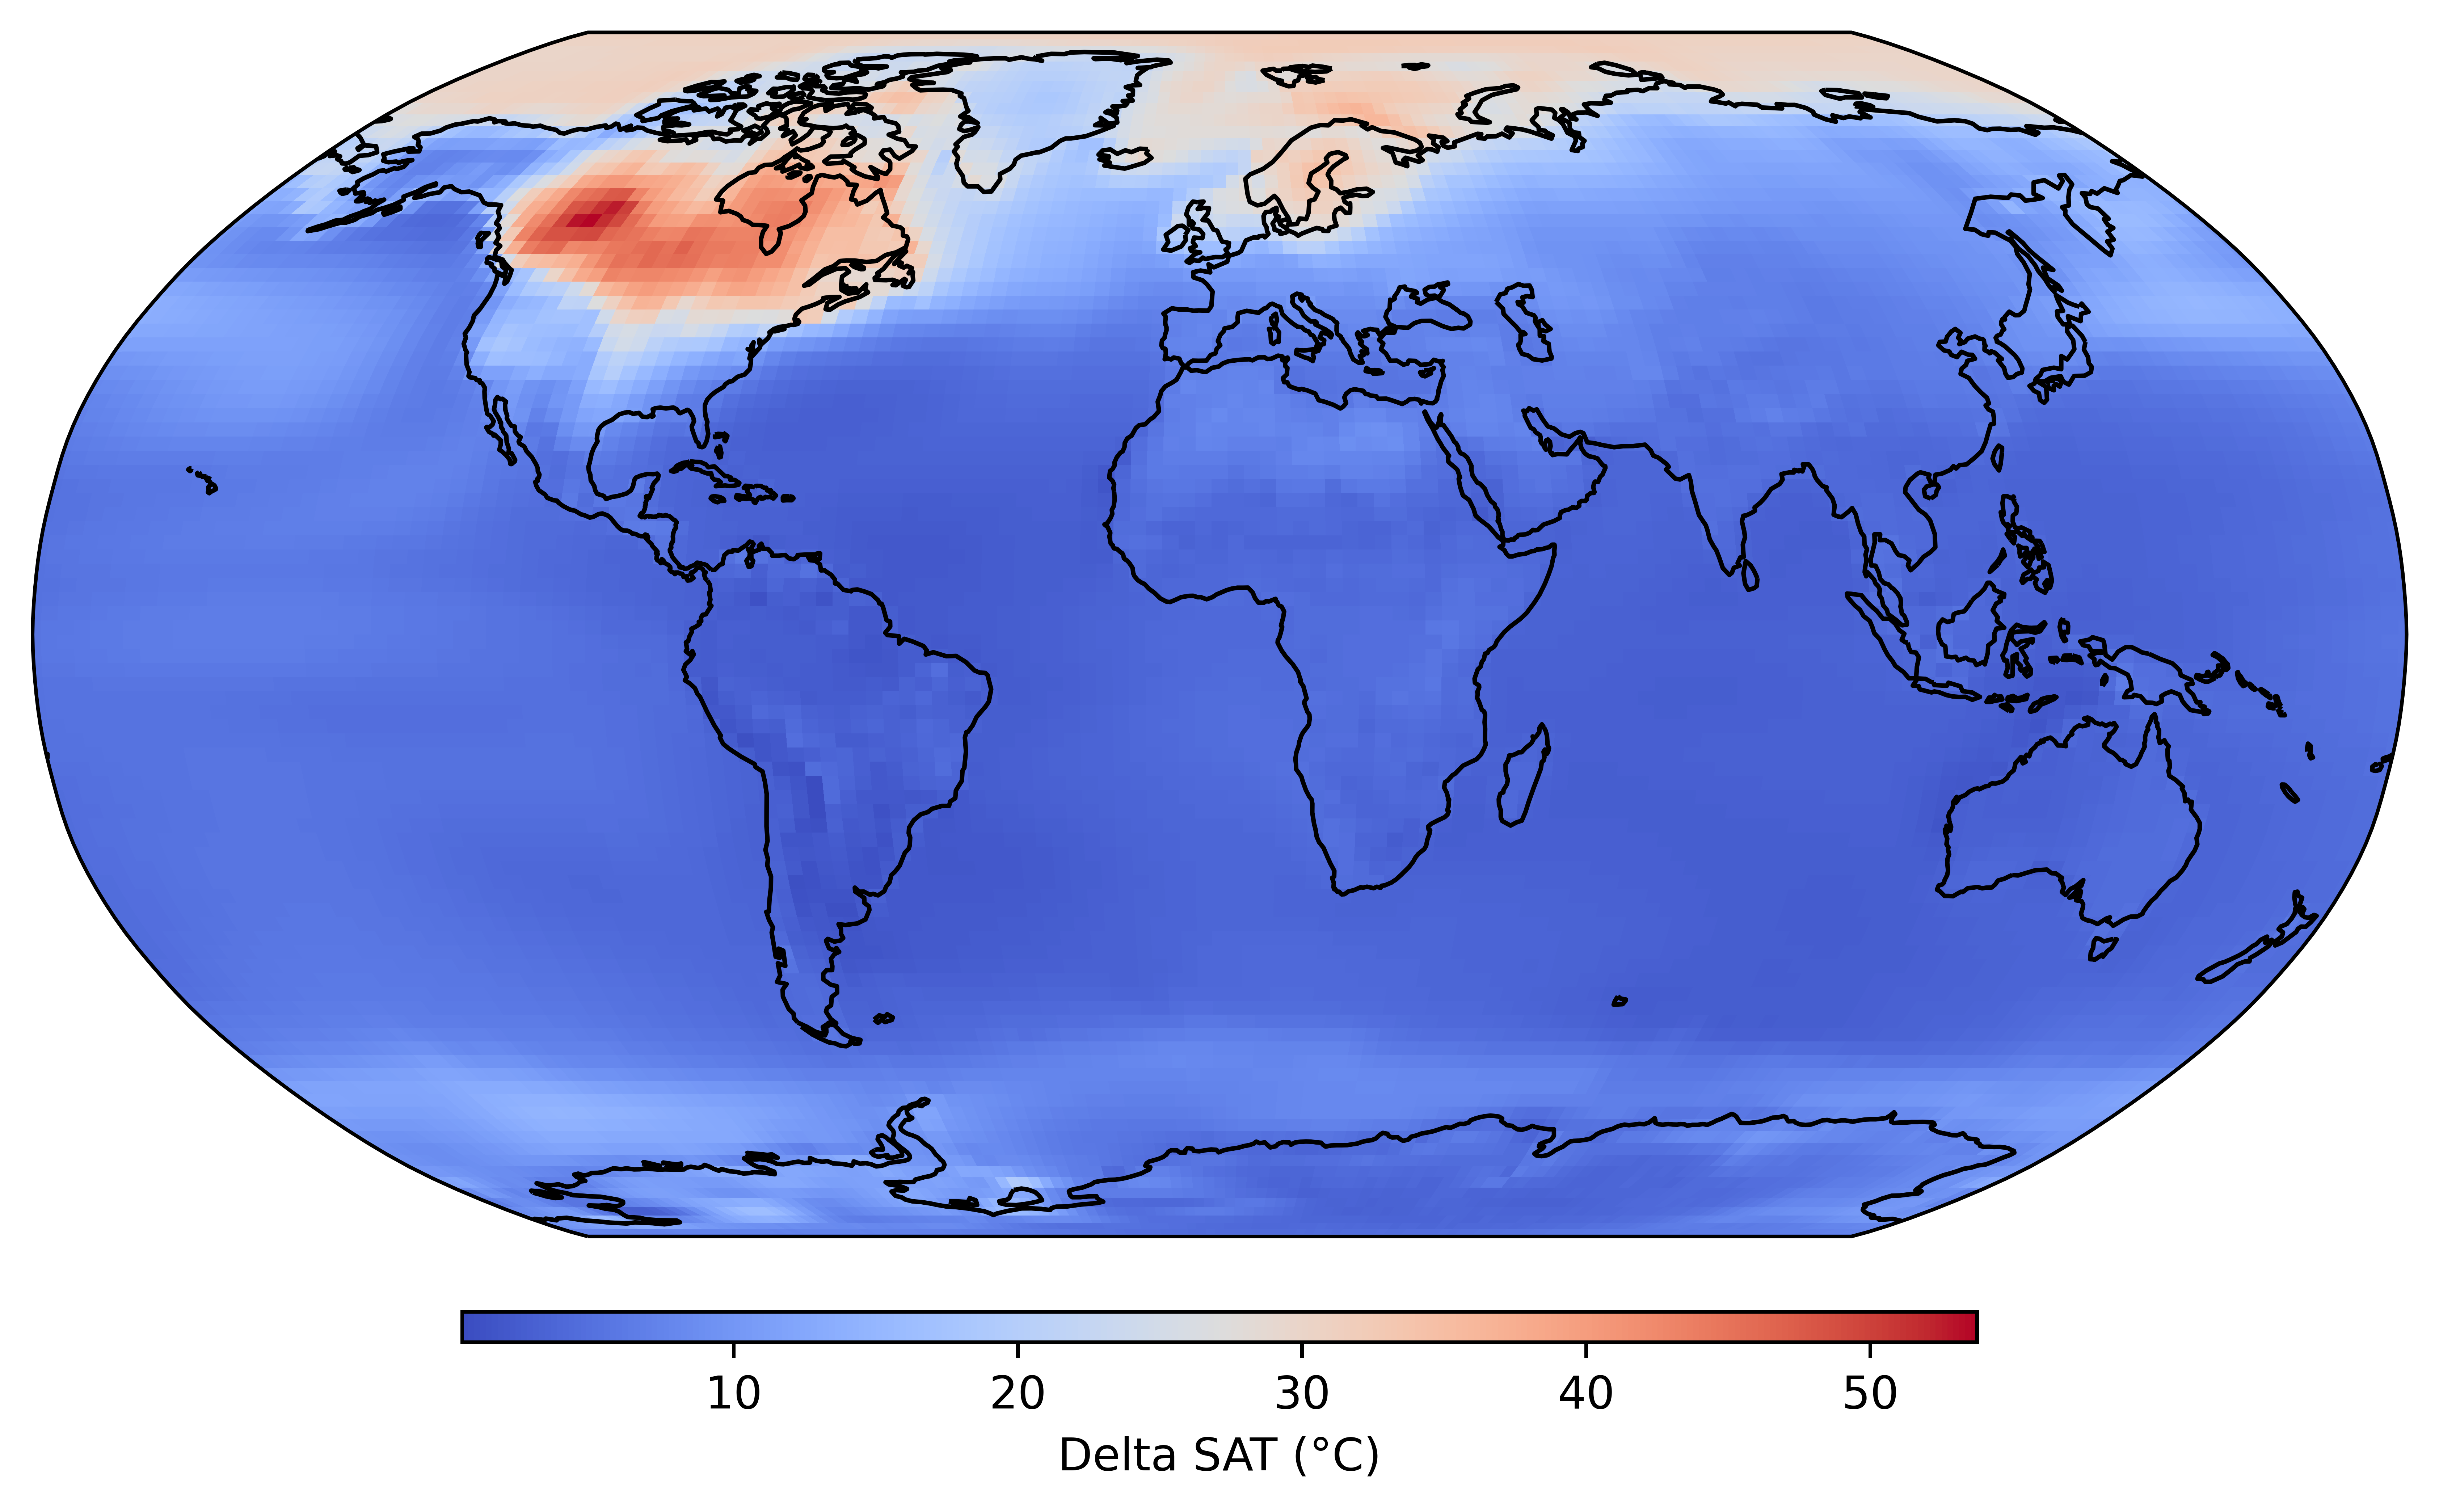

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

# Calculate the difference in SAT between the first and last age values
sat_diff =  ds_sat['sat'].sel(age=1000,method='nearest')-ds_sat['sat'].sel(age=17000,method='nearest') 
# sat_diff = ds_sat['sat'].isel(0) - ds_sat['sat'].isel(-1)

# Plotting
fig = plt.figure(figsize=(12, 6),dpi=900)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()

# Plot the difference
sat_diff_plot = ax.pcolormesh(ds_sat['lon'], ds_sat['lat'], sat_diff, transform=ccrs.PlateCarree(), cmap='coolwarm')

# Add a colorbar
cbar = plt.colorbar(sat_diff_plot, orientation='horizontal', pad=0.05, aspect=50, shrink=0.5)
cbar.set_label('Delta SAT (°C)')

# plt.title('LGMR SAT Differences between 22000 and 1000 yr BP')
plt.show()


shape of the weight: (96,)
shape of the reshaped sat_centered_weighted: (120, 13824)


d:\Users\User\anaconda3\envs\pz_venv_causal\lib\site-packages\xarray\coding\variables.py:147: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


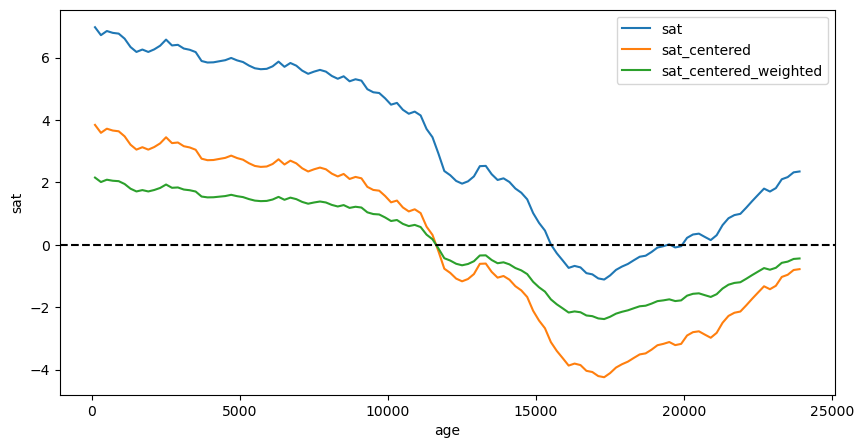

In [14]:
from toolbox import PCA_functions as pf
# 1. Center the Data
ds_sat = pf.center_data(ds_sat)

# 2. Weight the Data
ds_sat = pf.apply_weighting(ds_sat)

# 3. Plot the Centered and Weighted Data
lat_index = 77
lon_index = 90
pf.plot_sat_variables(ds_sat, lat_index, lon_index)

In [15]:
# read the csv files
import pandas as pd
df_pre = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\pre.csv")
df_obl = pd.read_csv(r"D:\VScode\Inso_LGMR\inso_data\obl.csv")
df_obl

,age,obl
0,100.0,0.409320
1,300.0,0.409773
2,500.0,0.410226
3,700.0,0.410678
4,900.0,0.411129
...,...,...
115,23100.0,0.395186
116,23300.0,0.394702
117,23500.0,0.394229
118,23700.0,0.393768


In [8]:
ds_sat.info()

xarray.Dataset {
dimensions:
	lat = 96 ;
	lon = 144 ;
	age = 120 ;

variables:
	float32 lat(lat) ;
	float32 lon(lon) ;
		lon:FillValue = 9.969209968386869e+36 ;
		lon:long_name = vector of longitudes ;
		lon:units = degrees_east ;
	float32 age(age) ;
		age:long_name = reconstruction bin mid-point (years BP) ;
	float32 sat(age, lat, lon) ;
		sat:FillValue = 9.969209968386869e+36 ;
		sat:long_name = ENSEMBLE MEAN (n = 500) mean annual temperature at reference height ;
		sat:units = degrees Celsius ;
	float32 sat_std(age, lat, lon) ;
		sat_std:FillValue = 9.969209968386869e+36 ;
		sat_std:long_name = ENSEMBLE STANDARD DEVIATION (n = 500) mean annual temperature at reference height ;
		sat_std:units = degrees Celsius ;
	float32 sat_centered(age, lat, lon) ;
	float32 weight(lat) ;
	float32 sat_centered_weighted(age, lat, lon) ;

// global attributes:
}

   LibSize       X:Y       Y:X
0     10.0  0.121869  0.614266
1     20.0  0.123194  0.720247
2     30.0  0.182668  0.745809
3     40.0  0.203779  0.740496
Columns: Index(['LibSize', 'X:Y', 'Y:X'], dtype='object')


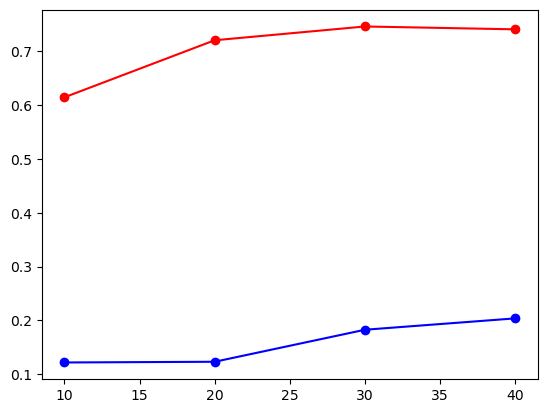

In [25]:
import pandas as pd
import numpy as np
from pyEDM import CCM


# Prepare DataFrame
df = pd.DataFrame({
    'Time': ds_sat['age'].values,
    'X': df_pre['pre'].values,
    'Y': ds_sat['sat'].isel(lat=80).isel(lon=0).values
})

# # plot df
# plt.plot(df['Time'], df['X'], 'b-')
# plt.plot(df['Time'], df['Y'], 'r-')



# CCM call
ccm_out = CCM(
    dataFrame   = df,
    E           = 2,
    tau         = 1,
    columns     = "X",   # predictor
    target      = "Y",   # target
    libSizes    = "10 20 30 40",
    sample      = 10,
    random      = True,
    replacement = False,
    Tp          = 0
)

print(ccm_out)
print("Columns:", ccm_out.columns)

# plot the results
plt.plot(ccm_out['LibSize'], ccm_out['X:Y'], 'bo-')
plt.plot(ccm_out['LibSize'], ccm_out['Y:X'], 'ro-')

In [18]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# PyEDM for Convergent Cross Mapping
from pyEDM import CCM

# ---------------------------
# 1) Suppose ds_sat (xarray.Dataset) and df_pre (pandas.DataFrame)
#    are already loaded and have matching time dimension: 120 time steps.
#    ds_sat has dims: (age=120, lat=96, lon=144)
#    ds_sat['sat'] -> shape (120, 96, 144)
#    df_pre has columns ['age','pre'] (120 rows)
# ---------------------------

# Make sure df_pre is sorted by 'age' if not already
df_pre = df_pre.sort_values(by='age').reset_index(drop=True)

# Grab your primary time series (shape = (120,))
pre_ts = df_pre['pre'].values

# ---------------------------
# 2) Define a helper function to run CCM (X->Y) for two 1D arrays
# ---------------------------
def run_ccm(x, y, E=3, tau=1, lib_sizes="10 20 30 40 50 60 70 80 90 100"):
    """
    Perform Convergent Cross Mapping using pyEDM.
    
    Parameters
    ----------
    x, y : 1D numpy arrays of the same length (time series).
    E    : embedding dimension (default=3).
    tau  : time lag (default=1).
    lib_sizes : library sizes to use when computing CCM 
                (must be a string like "10 20 30 ...", or a list, etc.)

    Returns
    -------
    final_rho : float
        The cross-map correlation (rho) at the largest library size.
    """
    # Build a small DataFrame for pyEDM
    df = pd.DataFrame({
        'Time': np.arange(len(x)),  # pyEDM uses "Time" or "time" as a key column
        'X': x,
        'Y': y
    })

    # Run CCM from X->Y:
    #   - columns='X': predictor
    #   - target='Y'
    ccm_out = CCM(
        dataFrame = df,
        E         = E,
        tau       = tau,
        columns   = "X",
        target    = "Y",
        libSizes  = lib_sizes,  # <-- NOTE: must use 'libSizes' instead of 'librarySizes'
        sample    = 100,        # number of random samples at each lib size
        random    = True,       # randomize library samples
        replacement = False,
        Tp        = 0           # Forecast interval (often set to 0 for cross-mapping)
    )
    # ccm_out is a DataFrame with columns like: LibrarySize, rho, MAE, RMSE, etc.

    # We'll take the correlation (rho) at the largest library size:
    final_rho = ccm_out['rho'].iloc[-1]
    return final_rho

# ---------------------------
# 3) Create a 2D array to store the CCM skill at each (lat, lon)
# ---------------------------
lats = ds_sat['lat'].values
lons = ds_sat['lon'].values
ccm_skill = np.full((len(lats), len(lons)), np.nan, dtype=float)

# ---------------------------
# 4) Loop over all grid points, compute CCM skill
# ---------------------------
for i in range(len(lats)):
    for j in range(len(lons)):
        # Extract the local time series from ds_sat
        sat_ts = ds_sat['sat'].isel(age=slice(None), lat=i, lon=j).values  # shape (120,)

        # Handle missing data (NaNs). Example: skip if any are present
        if np.isnan(sat_ts).any() or np.isnan(pre_ts).any():
            continue
        
        # Or, if partial NaNs, drop them pairwise:
        # valid_idx = ~np.isnan(sat_ts) & ~np.isnan(pre_ts)
        # x_val = pre_ts[valid_idx]
        # y_val = sat_ts[valid_idx]
        # if len(x_val) < some_min_length:
        #     continue
        # skill = run_ccm(x_val, y_val, E=3, tau=1)

        skill = run_ccm(pre_ts, sat_ts, E=3, tau=1)
        ccm_skill[i, j] = skill

# ---------------------------
# 5) Convert ccm_skill to an xarray.DataArray for easy plotting
# ---------------------------
skill_da = xr.DataArray(
    data=ccm_skill,
    dims=("lat", "lon"),
    coords={"lat": ds_sat["lat"], "lon": ds_sat["lon"]},
    name="CCM_skill"
)

# ---------------------------
# 6) Plot the resulting skill map
# ---------------------------
skill_da.plot()
plt.title("CCM skill (pre -> sat)")
plt.show()

# ---------------------------
# 7) (Optional) save to NetCDF
# ---------------------------
skill_da.to_netcdf("ccm_skill_map.nc")



KeyError: 'rho'